In [1]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from S2P import ShortSeq2PointDisaggregator
import time
import metrics

In [2]:
print("========== OPEN DATASETS ============")
train_house02 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train_house03 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train_house02.set_window(end="5-2-2011")
train_house03.set_window(end="28-4-2011")

val = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
val.set_window(start="16-5-2011")

test = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
test.set_window(end="5-3-2011")

train_building = [2,3]
val_building = 1
test_building = 1
sample_period = 3
meter_key = 'fridge'

train_mains = []
train_mains.append(train_house02.buildings[train_building[0]].elec.mains().all_meters()[1])
train_mains.append(train_house03.buildings[train_building[1]].elec.mains().all_meters()[0])
# train_mains.append(train.buildings[train_building[2]].elec.mains().all_meters()[0])

train_meters = []
train_meters.append(train_house02.buildings[train_building[0]].elec.submeters()[meter_key])
train_meters.append(train_house03.buildings[train_building[1]].elec.submeters()[meter_key])


test_mains = test.buildings[test_building].elec.mains().all_meters()[0]
test_meters = test.buildings[test_building].elec.submeters()[meter_key]

val_mains = val.buildings[val_building].elec.mains().all_meters()[0]
val_meters = val.buildings[val_building].elec.submeters()[meter_key]

S2P = ShortSeq2PointDisaggregator(window_size=100)

========== OPEN DATASETS ============
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 30)           330       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 30)           7230      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 40)           7240      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 50)           10050     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 50)           12550     
_________________________________________________________________
dropout_1 (Dropout

In [3]:
start = time.time()
print("========== TRAIN ============")

history01 = S2P.train(train_mains[0], train_meters[0], epochs=10)
history02 = S2P.train(train_mains[1], train_meters[1], epochs=10)

S2P.export_model("model_CNN_win100.h5")

end = time.time()
print("Train =", end-start, "seconds.")

========== TRAIN ============
(312888, 100, 1)
(312888,)
356.2344
84.37994
219.84592
61.480576
128
Epoch 1/10
1956/1956 [==============================] - 33s 12ms/step - loss: 0.1815 - val_loss: 0.1334
Epoch 2/10
1956/1956 [==============================] - 23s 12ms/step - loss: 0.1190 - val_loss: 0.0976
Epoch 3/10
1956/1956 [==============================] - 24s 12ms/step - loss: 0.1035 - val_loss: 0.1113
Epoch 4/10
1956/1956 [==============================] - 23s 12ms/step - loss: 0.0858 - val_loss: 0.0997
Epoch 5/10
1956/1956 [==============================] - 22s 11ms/step - loss: 0.0740 - val_loss: 0.0808
Epoch 6/10
1956/1956 [==============================] - 24s 12ms/step - loss: 0.0752 - val_loss: 0.1114
Epoch 7/10
1956/1956 [==============================] - 33s 17ms/step - loss: 0.0640 - val_loss: 0.0921
Epoch 8/10
1956/1956 [==============================] - 21s 11ms/step - loss: 0.0649 - val_loss: 0.0971
Epoch 9/10
1956/1956 [==============================] - 32s 16ms/step

In [4]:
print("========== DISAGGREGATE ============")
disag_filename = 'disag_CNN_win100.h5'
output = HDFDataStore(disag_filename, 'w')
S2P.disaggregate(test_mains, output, train_meters[0], sample_period=sample_period)
output.close()

========== DISAGGREGATE ============
New sensible chunk: 5533
New sensible chunk: 26611
New sensible chunk: 7822
New sensible chunk: 6689
New sensible chunk: 653
New sensible chunk: 29766
New sensible chunk: 13757
New sensible chunk: 32510
New sensible chunk: 34806
New sensible chunk: 20284
New sensible chunk: 64862
New sensible chunk: 525
New sensible chunk: 31931
New sensible chunk: 41483
New sensible chunk: 37554
New sensible chunk: 8252


========== Plot ============


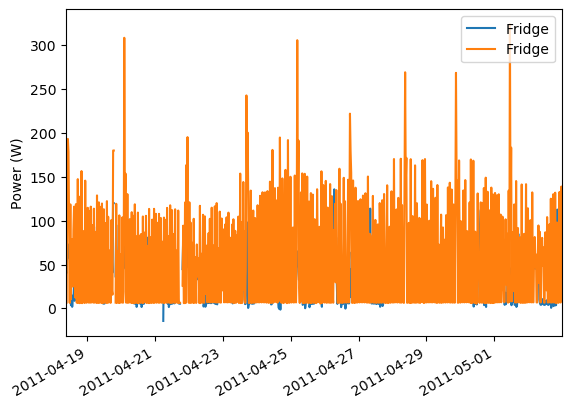

In [5]:
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec

print("========== Plot ============")

predicted = res_elec[meter_key]
ground_truth = test_meters
import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [6]:
good_sections_pre = predicted.good_sections()
good_sections_pre

[TimeFrame(start='2011-04-18 09:27:06-04:00', end='2011-04-18 13:58:45-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:08:03-04:00', end='2011-04-19 12:13:36-04:00', empty=False),
 TimeFrame(start='2011-04-19 12:19:12-04:00', end='2011-04-19 18:45:18-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:25:03-04:00', end='2011-04-20 01:54:30-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:00:33-04:00', end='2011-04-20 02:28:12-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:33:48-04:00', end='2011-04-21 03:17:06-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:22:12-04:00', end='2011-04-21 17:45:03-04:00', empty=False),
 TimeFrame(start='2011-04-21 19:46:24-04:00', end='2011-04-22 22:46:54-04:00', empty=False),
 TimeFrame(start='2011-04-22 22:53:30-04:00', end='2011-04-24 03:48:48-04:00', empty=False),
 TimeFrame(start='2011-04-24 03:57:21-04:00', end='2011-04-24 20:46:33-04:00', empty=False),
 TimeFrame(start='2011-04-24 20:52:12-04:00', end='2011-04-27 02:50:18

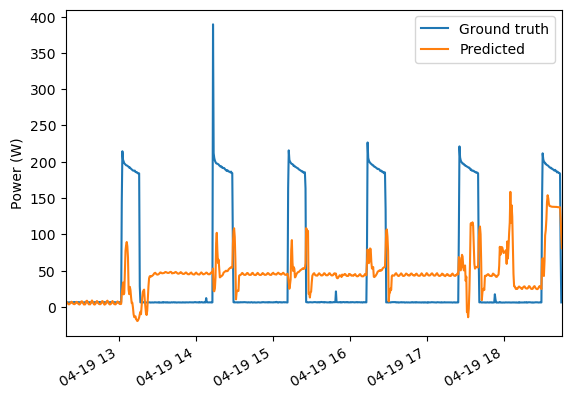

In [7]:
ground_truth.plot(timeframe=good_sections_pre[2])
predicted.plot(timeframe=good_sections_pre[2])
plt.legend(['Ground truth', 'Predicted'])
plt.show()

In [8]:
print(history01)
print(history02)

{'loss': [0.18154677748680115, 0.11903558671474457, 0.10347616672515869, 0.08580386638641357, 0.07395882904529572, 0.07522255182266235, 0.063983254134655, 0.06490826606750488, 0.06106572225689888, 0.06215391308069229], 'val_loss': [0.13338914513587952, 0.09757603704929352, 0.11125411093235016, 0.09974853694438934, 0.08082117885351181, 0.11140454560518265, 0.09206975996494293, 0.09707098454236984, 0.10150210559368134, 0.10470689833164215]}
{'loss': [0.5843018889427185, 0.5595564842224121, 0.5504763722419739, 0.5407917499542236, 0.537498414516449, 0.5309458374977112, 0.5272244215011597, 0.5245428085327148, 0.5213019847869873, 0.5193871855735779], 'val_loss': [0.668113112449646, 0.71355140209198, 0.7050005197525024, 0.6908581852912903, 0.7940630316734314, 0.6956856846809387, 0.7546101808547974, 0.730960488319397, 0.7055971026420593, 0.7432546019554138]}


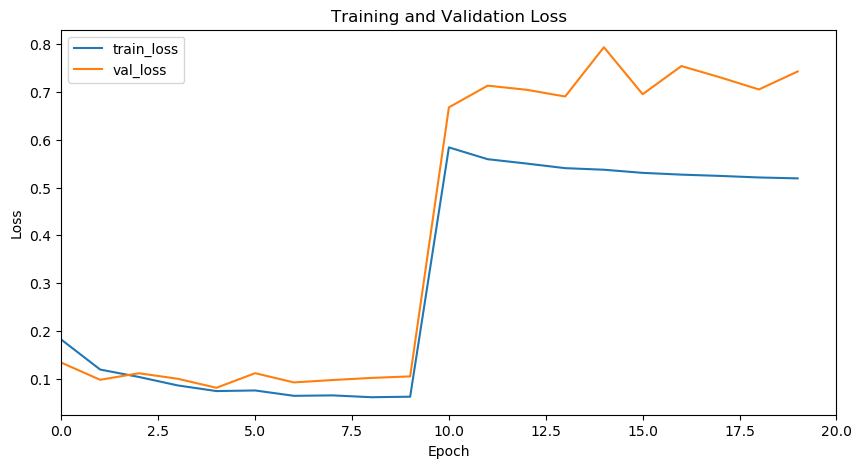

In [9]:
import matplotlib.pyplot as plt

# 第一个字典：训练损失和验证损失
history1 = {'loss': [0.18154677748680115, 0.11903558671474457, 0.10347616672515869, 0.08580386638641357, 0.07395882904529572, 0.07522255182266235, 0.063983254134655, 0.06490826606750488, 0.06106572225689888, 0.06215391308069229], 'val_loss': [0.13338914513587952, 0.09757603704929352, 0.11125411093235016, 0.09974853694438934, 0.08082117885351181, 0.11140454560518265, 0.09206975996494293, 0.09707098454236984, 0.10150210559368134, 0.10470689833164215]}

# 第二个字典：训练损失和验证损失
history2 = {'loss': [0.5843018889427185, 0.5595564842224121, 0.5504763722419739, 0.5407917499542236, 0.537498414516449, 0.5309458374977112, 0.5272244215011597, 0.5245428085327148, 0.5213019847869873, 0.5193871855735779], 'val_loss': [0.668113112449646, 0.71355140209198, 0.7050005197525024, 0.6908581852912903, 0.7940630316734314, 0.6956856846809387, 0.7546101808547974, 0.730960488319397, 0.7055971026420593, 0.7432546019554138]}

# 将两个字典合并
history = {'loss': history1['loss'] + history2['loss'],
           'val_loss': history1['val_loss'] + history2['val_loss']}

# 训练损失和验证损失列表
train_loss, val_loss = history['loss'], history['val_loss']

# 创建损失曲线
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_loss, label='train_loss')
ax.plot(val_loss, label='val_loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim([0, 20])
ax.legend()
plt.show()




In [3]:
print("========== RESULTS ============")
result = DataSet('disag_CNN_win100.h5')
res_elec = result.buildings[test_building].elec
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meters)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meters)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meters)))

========== RESULTS ============
============ Recall: 0.7448976873068315
============ Precision: 0.431339725837184
============ Accuracy: 0.4861373565110572
============ F1 Score: 0.5463250201519334
============ Relative error in total energy: 0.12764044331277366
============ Mean absolute error(in Watts): 56.82427005798716
